In [1]:
!pip install --quiet tqdm neo4j seaborn tiktoken langchain-openai langchain-community langchain-core

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
graphrag 0.3.2 requires tenacity<10.0.0,>=9.0.0, but you have tenacity 8.5.0 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Integrating Microsoft GraphRAG into Neo4j
## Store the MSFT GraphRAG output into Neo4j and implement local and global retrievers with LangChain or LlamaIndex

[Microsoft's GraphRAG implementation](https://microsoft.github.io/graphrag/) has gained significant attention lately. In my [last blog post](https://medium.com/neo4j/implementing-from-local-to-global-graphrag-with-neo4j-and-langchain-constructing-the-graph-73924cc5bab4), I discussed how the graph is constructed and explored some of the innovative aspects highlighted in the research paper. At a high level, the input to the GraphRAG library are source documents containing various information. The documents are processed using an Large Language Model (LLM) to extract structured information about entities appearing in the documents along with their relationships. This extracted structured information is then used to construct a knowledge graph.

![image](https://cdn-images-1.medium.com/max/800/0*3-dqkOcFxHEYMRKP.png)

After the knowledge graph has been constructed, the GraphRAG library uses a combination of graph algorithms, specifically Leiden community detection algorithm, and LLM prompting to generate natural language summaries of communities of entities and relationships found in the knowledge graph.
In this post, we'll take the output from the GraphRAG library, store it in Neo4j, and then set up retrievers directly from Neo4j using LangChain and LlamaIndex orchestration frameworks.
The code and GraphRAG output are accessible on GitHub, allowing you to skip the GraphRAG extraction process.
## Dataset
The dataset featured in this blog post is "A Christmas Carol" by Charles Dickens, which is freely accessible via the Gutenberg Project.

We selected this book as the source document because it is highlighted in the introductory documentation, allowing us to perform the extraction effortlessly.

## Graph construction
Even though you can skip the graph extraction part, we'll talk about a couple of configuration options I think are the most important. For example, graph extraction can be very token-intensive and costly. Therefore, testing the extraction with a relatively cheap but good-performing LLM like gpt-4o-mini makes sense. The cost reduction from gpt-4-turbo can be significant while retaining good accuracy, as described in this blog post.
```
GRAPHRAG_LLM_MODEL=gpt-4o-mini
```

The most important configuration is the type of entities we want to extract. By default, organizations, people, events, and geo are extracted.
```
GRAPHRAG_ENTITY_EXTRACTION_ENTITY_TYPES=organization,person,event,geo
```
These default entity types might work well for a book, but make sure to change them accordingly to the domain of the documents you are looking at processing for a given use case.
Another important configuration is the max gleanings value. The authors identified, and we also validated separately, that an LLM doesn't extract all the available information in a single extraction pass.

![image](https://cdn-images-1.medium.com/max/800/0*Dur0l2MdEydVntKK.png)

The gleaning configuration allows the LLM to perform multiple extraction passes. In the above image, we can clearly see that we extract more information when performing multiple passes (gleanings). Multiple passes are token-intensive, so a cheaper model like gpt-4o-mini helps to keep the cost low.
```
GRAPHRAG_ENTITY_EXTRACTION_MAX_GLEANINGS=1
```
Additionally, the claims or covariate information is not extracted by default. You can enable it by setting the GRAPHRAG_CLAIM_EXTRACTION_ENABLED configuration. 
```
GRAPHRAG_CLAIM_EXTRACTION_ENABLED=False
GRAPHRAG_CLAIM_EXTRACTION_MAX_GLEANINGS=1
```
It seems that it's a recurring theme that not all structured information is extracted in a single pass. Hence, we have the gleaning configuration option here as well.
What's also interesting, but I haven't had time to dig deeper is the prompt tuning section. Prompt tuning is optional, but highly encouraged as it can improve accuracy.

After the configuration has been set, we can follow the instructions to run the graph extraction pipeline, which consists of the following steps.

![image](https://cdn-images-1.medium.com/max/800/0*s-p5ysea5rpKN8Sf.png)

The extraction pipeline executes all the blue steps in the above image. Review my [previous blog post](https://medium.com/neo4j/implementing-from-local-to-global-graphrag-with-neo4j-and-langchain-constructing-the-graph-73924cc5bab4) to learn more about graph construction and community summarization. The output of the graph extraction pipeline of the MSFT GraphRAG library is a set of parquet files, as shown in the [Operation Dulce example](https://github.com/microsoft/graphrag/tree/main/examples_notebooks/inputs/operation%20dulce).

These parquet files can be easily imported into the Neo4j graph database for downstream analysis, visualization, and retrieval. We can use a free cloud Aura instance or set up a local Neo4j environment. My friend Michael Hunger did most of the work to import the parquet files into Neo4j. We'll skip the import explanation in this blog post, but it consists of importing and constructing a knowledge graph from five or six CSV files. If you want to learn more about CSV importing, you can check the Neo4j Graph Academy course.

The import code is available as a [Jupyter notebook on GitHub](https://github.com/tomasonjo/blogs/blob/master/msft_graphrag/ms_graphrag_import.ipynb) along with the example GraphRAG output.

In [ ]:
! pip install llama-index


In [9]:
! pip uninstall  llama-index-graph-stores-neo4j

^C


In [ ]:
! pip --quiet install llama-index-vector-stores-neo4jvector

In [1]:
import os
import getpass
from neo4j import GraphDatabase, Result
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken
import numpy as np
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Neo4jVector
from langchain_community.graphs import Neo4jGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from llama_index.core.schema import TextNode
from llama_index.core.vector_stores.utils import node_to_metadata_dict
from llama_index.vector_stores.neo4jvector import Neo4jVectorStore
from llama_index.core import VectorStoreIndex
from tqdm import tqdm


from typing import Dict, Any

# Adjust pandas display settings
pd.set_option(
    "display.max_colwidth", None
)  # Set to None to display the full column width
pd.set_option("display.max_columns", None)

## Graph analysis
Before moving onto retriever implementation, we'll perform a simple graph analysis to familiarize ourselves with the extracted data. We start by defining the database connection and a function that executes a Cypher statement (graph database query language) and outputs a Pandas DataFrame.

In [2]:
NEO4J_URI = "bolt://localhost"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "AP585576ice"
NEO4J_DATABASE = "testzh"  # 指定数据库名

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

def db_query(cypher: str, params: Dict[str, Any] = {}) -> pd.DataFrame:
    """Executes a Cypher statement and returns a DataFrame"""
    with driver.session(database=NEO4J_DATABASE) as session:  # 指定数据库
        result = session.run(cypher, params)
        return pd.DataFrame([dict(record) for record in result])

In [34]:
from dotenv import load_dotenv


load_dotenv()

True

In [68]:
os.environ["OPENAI_API_KEY"] = "sk-35lrdhpVMZvp8zdYidHsyh1tksbFhRG7KG9HEtsy9WZeYEAV"
os.environ["OPENAI_API_BASE"] = "https://api.fe8.cn/v1"

When performing the graph extraction, we used a chunk size of 300. Since then, the authors have changed the default chunk size to 1200. We can validate the chunk sizes using the following Cypher statement.

In [3]:
db_query("MATCH (n:__Chunk__) RETURN n.n_tokens as token_count, count(*) AS count")

,token_count,count
0,12,9
1,200,2
2,216,3
3,271,1
4,283,2
...,...,...
57,228,1
58,227,1
59,225,1
60,104,1


230 chunks have 300 tokens, while the last one has only 155 tokens. Let's now check an example entity and its description.

In [4]:
db_query(
    "MATCH (n:__Entity__) RETURN n.name AS name, n.description AS description LIMIT 1"
)

,name,description
0,五行山,五行山是一个著名的佛教圣地，位于真实的地理位置。它不仅是佛教徒朝圣的重要地点，也是佛教文化的重要象征。五行山曾是佛教徒指路作标记的五座联山之一，用于压住妖气。此外，它还是佛教圣地，被视作通往佛祖的路径，其神秘空间被严密监控。五行山是佛教圣地，被压在妖气之下，后来被揭开。最后，五行山山顶曾是佛教圣地，被佛祖祝福，成为信徒们向往的圣地。


It seems that the project Gutenberg is described in the book somewhere, probably at the beginning. We can observe how a description can capture more detailed and intricate information than just an entity name, which the MSFT GraphRAG paper introduced to retain more sophisticated and nuanced data from text.

Let's check example relationships as well.

In [5]:
db_query("MATCH ()-[n:RELATED]->() RETURN n.description AS description LIMIT 5")

,description
0,五行山是取真经的地点，因此五行山与真经事件相关
1,王莽造反时，五行山从天而降，压住了孙悟空
2,孙悟空被如来压在五行山下
3,唐僧试图救出被压在五行山下的孙悟空
4,如来佛用手指化作了五行山，用来压住悟空


The MSFT GraphRAG goes beyond merely extracting simple relationship types between entities by capturing detailed relationship descriptions. This capability allows it to capture more nuanced information than straightforward relationship types.

We can also examine a single community and its generated descriptions.

In [6]:
db_query(
    """
  MATCH (n:__Community__) 
  RETURN n.title AS title, n.summary AS summary, n.full_content AS full_content LIMIT 1
"""
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: summary)} {position: line: 3, column: 32, offset: 57} for query: '\n  MATCH (n:__Community__) \n  RETURN n.title AS title, n.summary AS summary, n.full_content AS full_content LIMIT 1\n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you r

,title,summary,full_content
0,Community 3,None,None


A community has a title, summary, and full content generated using an LLM. I haven't seen if the authors use the full context or just the summary during retrieval, but we can choose between the two. We can observe citations in the full_content, which point to entities and relationships from which the information came. It's funny that an LLM sometimes trims the citations if they are too long, like in the following example.

```
[Data: Entities (11, 177); Relationships (25, 159, 20, 29, +more)]
```

There is no way to expand the `+more` sign, so this is a funny way of dealing with long citations by an LLM.
Let's now evaluate some distributions. We'll start by inspecting the distribution of the count of extracted entities from text chunks.

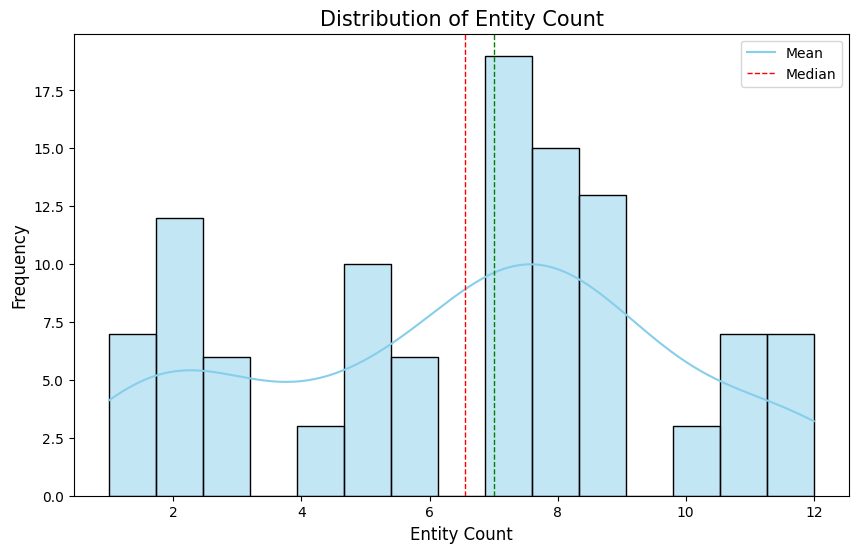

In [7]:
entity_df = db_query(
    """
MATCH (d:__Chunk__)
RETURN count {(d)-[:HAS_ENTITY]->()} AS entity_count
"""
)
# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(entity_df["entity_count"], kde=True, bins=15, color="skyblue")
plt.axvline(
    entity_df["entity_count"].mean(), color="red", linestyle="dashed", linewidth=1
)
plt.axvline(
    entity_df["entity_count"].median(), color="green", linestyle="dashed", linewidth=1
)
plt.xlabel("Entity Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Entity Count", fontsize=15)
plt.legend(
    {
        "Mean": entity_df["entity_count"].mean(),
        "Median": entity_df["entity_count"].median(),
    }
)
plt.show()

Remember, text chunks have 300 tokens. Therefore, the number of extracted entities is relatively small, with an average of around three entities per text chunk. The extraction was done without any gleanings (a single extraction pass). It would be interesting to see the distribution if we increased the gleaning count.

Next, we will evaluate the node degree distribution. A node degree is the number of relationships a node has.

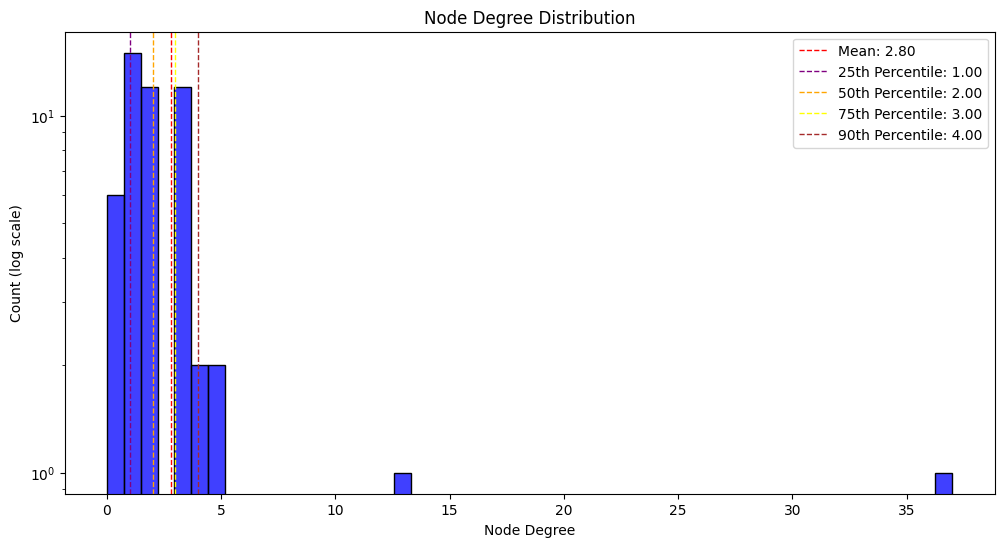

In [14]:
degree_dist_df = db_query(
    """
MATCH (e:__Entity__)
RETURN count {(e)-[:RELATED]-()} AS node_degree
"""
)
# Calculate mean and median
mean_degree = np.mean(degree_dist_df["node_degree"])
percentiles = np.percentile(degree_dist_df["node_degree"], [25, 50, 75, 90])
# Create a histogram with a logarithmic scale
plt.figure(figsize=(12, 6))
sns.histplot(degree_dist_df["node_degree"], bins=50, kde=False, color="blue")
# Use a logarithmic scale for the x-axis
plt.yscale("log")
# Adding labels and title
plt.xlabel("Node Degree")
plt.ylabel("Count (log scale)")
plt.title("Node Degree Distribution")
# Add mean, median, and percentile lines
plt.axvline(
    mean_degree,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label=f"Mean: {mean_degree:.2f}",
)
plt.axvline(
    percentiles[0],
    color="purple",
    linestyle="dashed",
    linewidth=1,
    label=f"25th Percentile: {percentiles[0]:.2f}",
)
plt.axvline(
    percentiles[1],
    color="orange",
    linestyle="dashed",
    linewidth=1,
    label=f"50th Percentile: {percentiles[1]:.2f}",
)
plt.axvline(
    percentiles[2],
    color="yellow",
    linestyle="dashed",
    linewidth=1,
    label=f"75th Percentile: {percentiles[2]:.2f}",
)
plt.axvline(
    percentiles[3],
    color="brown",
    linestyle="dashed",
    linewidth=1,
    label=f"90th Percentile: {percentiles[3]:.2f}",
)
# Add legend
plt.legend()
# Show the plot
plt.show()

Most real-world networks follow a power-law node degree distribution, with most nodes having relatively small degrees and some important nodes having a lot. While our graph is small, the node degree follows the power law. It would be interesting to identify which entity has 120 relationships (connected to 43% of entities).

In [8]:
db_query(
    """
  MATCH (n:__Entity__) 
  RETURN n.name AS name, count{(n)-[:RELATED]-()} AS degree
  ORDER BY degree DESC LIMIT 5"""
)

,name,degree
0,悟空,109
1,孙悟空,64
2,唐僧,40
3,观音菩萨,26
4,袈裟,18


Without any hesitation, we can assume that `Scrooge` is the book's main character. I would also venture a guess that `Ebenezer Scrooge` and `Scrooge` are actually the same entity, but as the MSFT GraphRAG lacks an entity resolution step, they weren't merged.
It also shows that analyzing and cleaning the data is a vital step to reducing noise information, as Project Gutenberg has 13 relationships, even though they are not part of the book story.

Lastly, we'll inspect the distribution of community size per hierarchical level.

C:\Users\iceHope\AppData\Local\Temp\ipykernel_20868\2680507823.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="level", y="members", data=community_data, palette="viridis")


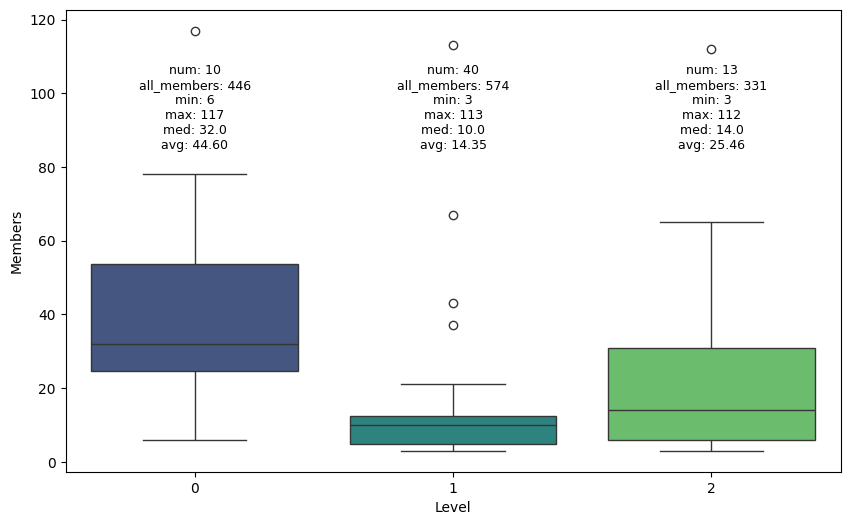

In [9]:
community_data = db_query(
    """
  MATCH (n:__Community__)
  RETURN n.level AS level, count{(n)-[:IN_COMMUNITY]-()} AS members
"""
)

stats = (
    community_data.groupby("level")
    .agg(
        min_members=("members", "min"),
        max_members=("members", "max"),
        median_members=("members", "median"),
        avg_members=("members", "mean"),
        num_communities=("members", "count"),
        total_members=("members", "sum"),
    )
    .reset_index()
)

# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="level", y="members", data=community_data, palette="viridis")
plt.xlabel("Level")
plt.ylabel("Members")

# Add statistical annotations
for i in range(stats.shape[0]):
    level = stats["level"][i]
    max_val = stats["max_members"][i]
    text = (
        f"num: {stats['num_communities'][i]}\n"
        f"all_members: {stats['total_members'][i]}\n"
        f"min: {stats['min_members'][i]}\n"
        f"max: {stats['max_members'][i]}\n"
        f"med: {stats['median_members'][i]}\n"
        f"avg: {stats['avg_members'][i]:.2f}"
    )
    plt.text(level, 85, text, horizontalalignment="center", fontsize=9)

plt.show()

The Leiden algorithm identified three levels of communities, where the communities on higher levels are larger on average. However, there are some technical details that I'm not aware of because if you check the all_members count, and you can see that each level has a different number of all nodes, even though they should be the same in theory. Also, if communities merge at higher levels, why do we have 19 communities on level 0 and 22 on level 1? The authors have done some optimizations and tricks here, which I haven't had a time to explore in detail yet.
## Implementing retrievers
In the last part of this blog post, we will discuss the local and global retrievers as specified in the MSFT GraphRAG. The retrievers will be implemented and integrated with LangChain and LlamaIndex.
### Local retriever
The local retriever starts by using vector search to identify relevant nodes, and then collects linked information and injects it into the LLM prompt.

![image](https://cdn-images-1.medium.com/max/800/1*lInV6WWTDXYEVI1NS3KV9g.png)

While this diagram might look complex, it can be easily implemented. We start by identifying relevant entities using a vector similarity search based on text embeddings of entity descriptions. Once the relevant entities are identified, we can traverse to related text chunks, relationships, community summaries, and so on. The pattern of using vector similarity search and then traversing throughout the graph can easily be implemented using a retrieval_query feature in both LangChain and LlamaIndex.

First, we need to configure the vector index.

In [10]:
index_name = "entity"

db_query(
    """
CREATE VECTOR INDEX """
    + index_name
    + """ IF NOT EXISTS FOR (e:__Entity__) ON e.description_embedding
OPTIONS {indexConfig: {
 `vector.dimensions`: 768,
 `vector.similarity_function`: 'cosine'
}}
"""
)

""


We'll also calculate and store the community weight, which is defined as the number of distinct text chunks the entities in the community appear.

In [11]:
db_query(
    """
MATCH (n:`__Community__`)<-[:IN_COMMUNITY]-()<-[:HAS_ENTITY]-(c)
WITH n, count(distinct c) AS chunkCount
SET n.weight = chunkCount"""
)

""


The number of candidates (text units, community reports, …) from each section is configurable. While the original implementation has slightly more involved filtering based on token counts, we'll simplify it here. I developed the following simplified top candidate filter values based on the default configuration values.

In [12]:
topChunks = 3
topCommunities = 3
topOutsideRels = 10
topInsideRels = 10
topEntities = 10

We will start with LangChain implementation. The only thing we need to define is the retrieval_query , which is more involved.

In [16]:
lc_retrieval_query = """
WITH collect(node) as nodes
// Entity - Text Unit Mapping
WITH
collect {
    UNWIND nodes as n
    MATCH (n)<-[:HAS_ENTITY]->(c:__Chunk__)
    WITH c, count(distinct n) as freq
    RETURN c.text AS chunkText
    ORDER BY freq DESC
    LIMIT $topChunks
} AS text_mapping,
// Entity - Report Mapping
collect {
    UNWIND nodes as n
    MATCH (n)-[:IN_COMMUNITY]->(c:__Community__)
    WITH c, c.rank as rank, c.weight AS weight
    RETURN c.summary 
    ORDER BY rank, weight DESC
    LIMIT $topCommunities
} AS report_mapping,
// Outside Relationships 
collect {
    UNWIND nodes as n
    MATCH (n)-[r:RELATED]-(m) 
    WHERE NOT m IN nodes
    RETURN r.description AS descriptionText
    ORDER BY r.rank, r.weight DESC 
    LIMIT $topOutsideRels
} as outsideRels,
// Inside Relationships 
collect {
    UNWIND nodes as n
    MATCH (n)-[r:RELATED]-(m) 
    WHERE m IN nodes
    RETURN r.description AS descriptionText
    ORDER BY r.rank, r.weight DESC 
    LIMIT $topInsideRels
} as insideRels,
// Entities description
collect {
    UNWIND nodes as n
    RETURN n.description AS descriptionText
} as entities
// We don't have covariates or claims here
RETURN {Chunks: text_mapping, Reports: report_mapping, 
       Relationships: outsideRels + insideRels, 
       Entities: entities} AS text, 1.0 AS score, {} AS metadata
"""
from langchain_community.embeddings import OllamaEmbeddings

lc_vector = Neo4jVector.from_existing_index(
    OllamaEmbeddings(model="mxbai-embed-large"),
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database="testzh",
    index_name=index_name,
    retrieval_query=lc_retrieval_query,
)
lc_vector._database="testzh"

ValueError: The provided embedding function and vector index dimensions do not match.
Embedding function dimension: 1024
Vector index dimension: 768

This Cypher query performs multiple analytical operations on a set of nodes to extract and organize related text data:
1. Entity-Text Unit Mapping: For each node, the query identifies linked text chunks (`__Chunk__`), aggregates them by the number of distinct nodes associated with each chunk, and orders them by frequency. The top chunks are returned as `text_mapping`.
2. Entity-Report Mapping: For each node, the query finds the associated community (`__Community__`), and returns the summary of the top-ranked communities based on rank and weight.
3. Outside Relationships: This section extracts descriptions of relationships (`RELATED`) where the related entity (`m`) is not part of the initial node set. The relationships are ranked and limited to the top external relationships.
4. Inside Relationships: Similarly to outside relationships, but this time it considers only relationships where both entities are within the initial set of nodes.
5. Entities Description: Simply collects descriptions of each node in the initial set.
Finally, the query combines the collected data into a structured result comprising of chunks, reports, internal and external relationships, and entity descriptions, along with a default score and an empty metadata object. You have the option to remove some of the retrieval parts to test how they affect the results.

And now you can run the retriever using the following code:

In [ ]:
docs = lc_vector.similarity_search(
    "What do you know about 机器学习",
    k=topEntities,
    params={
        "topChunks": topChunks,
        "topCommunities": topCommunities,
        "topOutsideRels": topOutsideRels,
        "topInsideRels": topInsideRels,
    },
)
print(docs[0].page_content)

The same retrieval pattern can be implemented with LlamaIndex. For LlamaIndex, we first need to add metadata to nodes so that the vector index will work. If the default metadata is not added to the relevant nodes, the vector index will return an error.

In [75]:
content = node_to_metadata_dict(TextNode(), remove_text=True, flat_metadata=False)

db_query(
    """
  MATCH (e:__Entity__)
  SET e += $content""",
    {"content": content},
)

""


Again, we can use the `retrieval_query` feature in LlamaIndex to define the retriever. Unlike with LangChain, we will use the f-string instead of query parameters to pass the top candidate filter parameters.

In [59]:
embed_dim = 768

retrieval_query = f"""
WITH collect(node) as nodes
// Entity - Text Unit Mapping
WITH
nodes,
collect {{
    UNWIND nodes as n
    MATCH (n)<-[:HAS_ENTITY]->(c:__Chunk__)
    WITH c, count(distinct n) as freq
    RETURN c.text AS chunkText
    ORDER BY freq DESC
    LIMIT {topChunks}
}} AS text_mapping,
// Entity - Report Mapping
collect {{
    UNWIND nodes as n
    MATCH (n)-[:IN_COMMUNITY]->(c:__Community__)
    WITH c, c.rank as rank, c.weight AS weight
    RETURN c.summary 
    ORDER BY rank, weight DESC
    LIMIT {topCommunities}
}} AS report_mapping,
// Outside Relationships 
collect {{
    UNWIND nodes as n
    MATCH (n)-[r:RELATED]-(m) 
    WHERE NOT m IN nodes
    RETURN r.description AS descriptionText
    ORDER BY r.rank, r.weight DESC 
    LIMIT {topOutsideRels}
}} as outsideRels,
// Inside Relationships 
collect {{
    UNWIND nodes as n
    MATCH (n)-[r:RELATED]-(m) 
    WHERE m IN nodes
    RETURN r.description AS descriptionText
    ORDER BY r.rank, r.weight DESC 
    LIMIT {topInsideRels}
}} as insideRels,
// Entities description
collect {{
    UNWIND nodes as n
    RETURN n.description AS descriptionText
}} as entities
// We don't have covariates or claims here
RETURN "Chunks:" + apoc.text.join(text_mapping, '|') + "\nReports: " + apoc.text.join(report_mapping,'|') +  
       "\nRelationships: " + apoc.text.join(outsideRels + insideRels, '|') + 
       "\nEntities: " + apoc.text.join(entities, "|") AS text, 1.0 AS score, nodes[0].id AS id, 
       {{_node_type:nodes[0]._node_type, _node_content:nodes[0]._node_content}} AS metadata
"""

Additionally, the return is slightly different. We need to return the node type and content as metadata; otherwise, the retriever will break. Now we just instantiate the Neo4j vector store and use it as a query engine.

In [62]:
from llama_index.embeddings.openai import OpenAIEmbedding

neo4j_vector = Neo4jVectorStore(
    NEO4J_USERNAME,
    NEO4J_PASSWORD,
    NEO4J_URI,
    embed_dim,
    index_name=index_name,
    retrieval_query=retrieval_query,
    database="test1"
)
loaded_index = VectorStoreIndex.from_vector_store(neo4j_vector).as_query_engine(
    similarity_top_k=topEntities, embed_model=OllamaEmbeddings(model="nomic-embed-text"),
)

We can now test the GraphRAG local retriever.

In [63]:
response = loaded_index.query("What do you know about 机器学习")
print(response.response)


Failed to write data to connection IPv4Address(('localhost', 7687)) (ResolvedIPv4Address(('127.0.0.1', 7687)))
Failed to write data to connection IPv4Address(('localhost', 7687)) (ResolvedIPv4Address(('127.0.0.1', 7687)))


AttributeError: 'OllamaEmbeddings' object has no attribute 'get_agg_embedding_from_queries'

In [ ]:
print(response.source_nodes[0].text)

One thing that immediately sparks to mind is that we can improve the local retrieval by using a hybrid approach (vector + keyword) to find relevant entities instead of vector search only.
## Global retriever
The global retriever architecture is slightly more straightforward. It seems to iterate over all the community summaries on a specified hierarchical level, producing intermediate summaries and then generating a final response based on the intermediate summaries.

![image](https://cdn-images-1.medium.com/max/800/1*mcDNDMTmCqVAUv1SnzTtzA.png)

We have to decide which define in advance which hierarchical level we want to iterate over, which is a not a simple decision as we have no idea which one would work better. The higher up you go the hierarchical level, the larger the communities get, but there are fewer of them. This is the only information we have without inspecting summaries manually.
Other parameters allow us to ignore communities below a rank or weight threshold, which we won't use here. We'll implement the global retriever using LangChain as use the same map and reduce prompts as in the GraphRAG paper.

In [76]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [77]:
MAP_SYSTEM_PROMPT = """
---Role---

You are a helpful assistant responding to questions about data in the tables provided.


---Goal---

Generate a response consisting of a list of key points that responds to the user's question, summarizing all relevant information in the input data tables.

You should use the data provided in the data tables below as the primary context for generating the response.
If you don't know the answer or if the input data tables do not contain sufficient information to provide an answer, just say so. Do not make anything up.

Each key point in the response should have the following element:
- Description: A comprehensive description of the point.
- Importance Score: An integer score between 0-100 that indicates how important the point is in answering the user's question. An 'I don't know' type of response should have a score of 0.

The response should be JSON formatted as follows:
{{
    "points": [
        {{"description": "Description of point 1 [Data: Reports (report ids)]", "score": score_value}},
        {{"description": "Description of point 2 [Data: Reports (report ids)]", "score": score_value}}
    ]
}}

The response shall preserve the original meaning and use of modal verbs such as "shall", "may" or "will".

Points supported by data should list the relevant reports as references as follows:
"This is an example sentence supported by data references [Data: Reports (report ids)]"

**Do not list more than 5 record ids in a single reference**. Instead, list the top 5 most relevant record ids and add "+more" to indicate that there are more.

For example:
"Person X is the owner of Company Y and subject to many allegations of wrongdoing [Data: Reports (2, 7, 64, 46, 34, +more)]. He is also CEO of company X [Data: Reports (1, 3)]"

where 1, 2, 3, 7, 34, 46, and 64 represent the id (not the index) of the relevant data report in the provided tables.

Do not include information where the supporting evidence for it is not provided.


---Data tables---

{context_data}

---Goal---

Generate a response consisting of a list of key points that responds to the user's question, summarizing all relevant information in the input data tables.

You should use the data provided in the data tables below as the primary context for generating the response.
If you don't know the answer or if the input data tables do not contain sufficient information to provide an answer, just say so. Do not make anything up.

Each key point in the response should have the following element:
- Description: A comprehensive description of the point.
- Importance Score: An integer score between 0-100 that indicates how important the point is in answering the user's question. An 'I don't know' type of response should have a score of 0.

The response shall preserve the original meaning and use of modal verbs such as "shall", "may" or "will".

Points supported by data should list the relevant reports as references as follows:
"This is an example sentence supported by data references [Data: Reports (report ids)]"

**Do not list more than 5 record ids in a single reference**. Instead, list the top 5 most relevant record ids and add "+more" to indicate that there are more.

For example:
"Person X is the owner of Company Y and subject to many allegations of wrongdoing [Data: Reports (2, 7, 64, 46, 34, +more)]. He is also CEO of company X [Data: Reports (1, 3)]"

where 1, 2, 3, 7, 34, 46, and 64 represent the id (not the index) of the relevant data report in the provided tables.

Do not include information where the supporting evidence for it is not provided.

The response should be JSON formatted as follows:
{{
    "points": [
        {{"description": "Description of point 1 [Data: Reports (report ids)]", "score": score_value}},
        {{"description": "Description of point 2 [Data: Reports (report ids)]", "score": score_value}}
    ]
}}
"""

map_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            MAP_SYSTEM_PROMPT,
        ),
        (
            "human",
            "{question}",
        ),
    ]
)

map_chain = map_prompt | llm | StrOutputParser()

In [78]:
REDUCE_SYSTEM_PROMPT = """
---Role---

You are a helpful assistant responding to questions about a dataset by synthesizing perspectives from multiple analysts.


---Goal---

Generate a response of the target length and format that responds to the user's question, summarize all the reports from multiple analysts who focused on different parts of the dataset.

Note that the analysts' reports provided below are ranked in the **descending order of importance**.

If you don't know the answer or if the provided reports do not contain sufficient information to provide an answer, just say so. Do not make anything up.

The final response should remove all irrelevant information from the analysts' reports and merge the cleaned information into a comprehensive answer that provides explanations of all the key points and implications appropriate for the response length and format.

Add sections and commentary to the response as appropriate for the length and format. Style the response in markdown.

The response shall preserve the original meaning and use of modal verbs such as "shall", "may" or "will".

The response should also preserve all the data references previously included in the analysts' reports, but do not mention the roles of multiple analysts in the analysis process.

**Do not list more than 5 record ids in a single reference**. Instead, list the top 5 most relevant record ids and add "+more" to indicate that there are more.

For example:

"Person X is the owner of Company Y and subject to many allegations of wrongdoing [Data: Reports (2, 7, 34, 46, 64, +more)]. He is also CEO of company X [Data: Reports (1, 3)]"

where 1, 2, 3, 7, 34, 46, and 64 represent the id (not the index) of the relevant data record.

Do not include information where the supporting evidence for it is not provided.


---Target response length and format---

{response_type}


---Analyst Reports---

{report_data}


---Goal---

Generate a response of the target length and format that responds to the user's question, summarize all the reports from multiple analysts who focused on different parts of the dataset.

Note that the analysts' reports provided below are ranked in the **descending order of importance**.

If you don't know the answer or if the provided reports do not contain sufficient information to provide an answer, just say so. Do not make anything up.

The final response should remove all irrelevant information from the analysts' reports and merge the cleaned information into a comprehensive answer that provides explanations of all the key points and implications appropriate for the response length and format.

The response shall preserve the original meaning and use of modal verbs such as "shall", "may" or "will".

The response should also preserve all the data references previously included in the analysts' reports, but do not mention the roles of multiple analysts in the analysis process.

**Do not list more than 5 record ids in a single reference**. Instead, list the top 5 most relevant record ids and add "+more" to indicate that there are more.

For example:

"Person X is the owner of Company Y and subject to many allegations of wrongdoing [Data: Reports (2, 7, 34, 46, 64, +more)]. He is also CEO of company X [Data: Reports (1, 3)]"

where 1, 2, 3, 7, 34, 46, and 64 represent the id (not the index) of the relevant data record.

Do not include information where the supporting evidence for it is not provided.


---Target response length and format---

{response_type}

Add sections and commentary to the response as appropriate for the length and format. Style the response in markdown.
"""

reduce_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            REDUCE_SYSTEM_PROMPT,
        ),
        (
            "human",
            "{question}",
        ),
    ]
)
reduce_chain = reduce_prompt | llm | StrOutputParser()

In [27]:
graph = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    refresh_schema=False,
)

response_type: str = "multiple paragraphs"


def global_retriever(query: str, level: int, response_type: str = response_type) -> str:
    community_data = graph.query(
        """
    MATCH (c:__Community__)
    WHERE c.level = $level
    RETURN c.full_content AS output
    """,
        params={"level": level},
    )
    intermediate_results = []
    for community in tqdm(community_data, desc="Processing communities"):
        intermediate_response = map_chain.invoke(
            {"question": query, "context_data": community["output"]}
        )
        intermediate_results.append(intermediate_response)
    final_response = reduce_chain.invoke(
        {
            "report_data": intermediate_results,
            "question": query,
            "response_type": response_type,
        }
    )
    return final_response

Let's now test it.

In [28]:
print(global_retriever("这个故事讲述了什么?用中文回答", 2))

Processing communities: 100%|██████████| 3/3 [00:10<00:00,  3.43s/it]


## 故事概述

这个故事围绕着肖虎及其团队在新地球社区的努力展开，重点在于新能源技术的开发以及应对由神秘病毒引发的生态危机。新地球面临着严峻的环境挑战，包括生态灭绝者病毒的传播和能源危机，这些问题严重威胁着生物多样性和人类的生存。

## 关键角色与团队合作

肖虎作为一位杰出的科学家，在社区中发挥着关键作用。他的领导能力和团队合作精神对于应对化学泄漏、病毒追踪等挑战至关重要。故事中强调了科学研究和团队协作在克服危机和确保社区安全中的重要性，肖虎与其他研究人员的合作展现了这一点。

## 研究中心与科技进步

故事的背景设定在2180年，主要围绕位于新地球的东方联盟科学与技术研究中心展开。该中心是社区的核心，推动科技创新和发展，并对周围社区产生重大影响。员工肖胡在研究中心的工作也可能对项目和技术突破产生重要影响，进一步揭示了个人在科学研究中的重要性。

## 生态危机的威胁

新地球正面临着重大的生态危机，特别是与某种病毒相关的威胁。尽管病毒的起源及其对生态系统的影响尚未明确，但社区对此表示高度关注，显示了人们对生态安全的重视。

## 总结

整体而言，这个故事通过肖虎及其团队的努力，展示了科学研究、团队合作以及科技进步在应对生态危机中的重要性。新地球的环境挑战不仅是科学探索的动力，也反映了人类对生存和发展的深刻思考。


## Summary
In this blog post we demonstrated how to integrate Microsoft's GraphRAG into Neo4j and implement retrievers using LangChain and LlamaIndex. This should allows you to integrate GraphRAG with other retrievers or agents seamlessly. The local retriever combines vector similarity search with graph traversal, while the global retriever iterates over community summaries to generate comprehensive responses. This implementation showcases the power of combining structured knowledge graphs with language models for enhanced information retrieval and question answering. It's important to note that there is room for customization and experimentation with such a knowledge graph, which we will look into in the next blog post.